[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\artem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Reading...
Drop empty data...
Making a lower case
Removing punctuation and stemming...


100%|██████████| 23640/23640 [03:33<00:00, 110.64it/s]


Splitting...
Fitting...


C:\Users\artem\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Predicting...
[0.95118864 0.16895431 1.01457384 ... 0.81729526 0.51974769 0.77563725]
Regression Metrics:
Accuracy: 0.7813028764805414
F1 Score: 0.8287512421331568


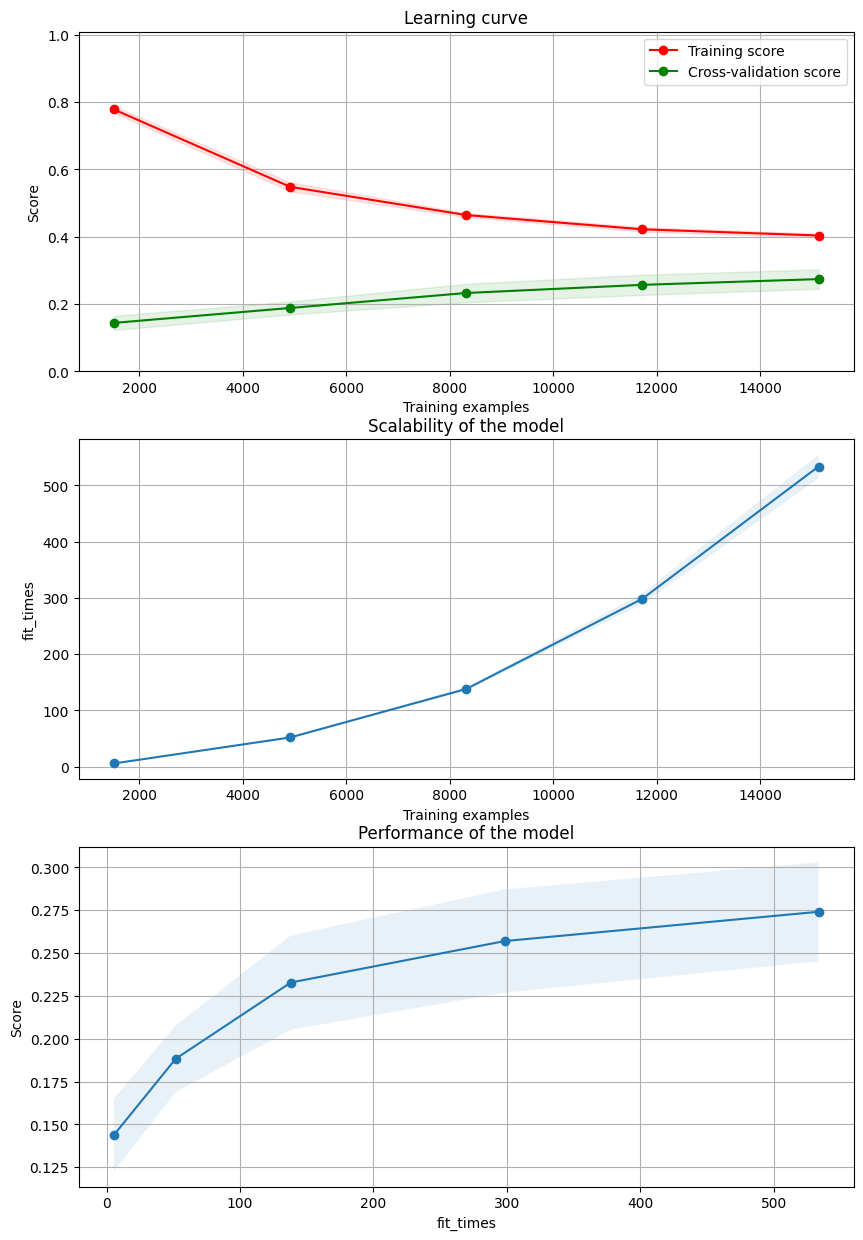

In [3]:
# pip install joblib pandas re tqdm nltk skicit-learn
import numpy as np
from matplotlib import pyplot as plt
from nltk import word_tokenize
from nltk.stem import LancasterStemmer
import nltk
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import re
import joblib
import pandas as pd
import sklearn
from lime.lime_text import LimeTextExplainer
from sklearn.linear_model import SGDClassifier, LogisticRegression
# from lime.lime_text import LimeTextExplainer
from sklearn.model_selection import ShuffleSplit, cross_val_score, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, mean_absolute_error, r2_score
from nltk.stem import PorterStemmer
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
# from sklearn.linear_model import SGDClassifier
# from sklearn.svm import SVR
from sklearn.svm import SVC, SVR

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# import numpy as np
def remove_links(text):
    return re.sub(r'http\S+', '', text)
tqdm.pandas()
# Load and preprocess the data while removing rows with empty cells
print("Reading...")
data = pd.read_csv('../bases/result.csv', na_values=[''])

print("Drop empty data...")
data.dropna(subset=['text'], inplace=True)  # Remove rows with empty 'text' cells
print("Making a lower case")
data['text'] = data['text'].str.lower()
print("Removing punctuation and stemming...")
stemmer = LancasterStemmer()
def remove_stopwords(text):
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return ' '.join(filtered_text)
data['text'] = data['text'].progress_apply(remove_stopwords)
# data['text'] = data['name'] + ' ' + data['text']
data['text'] = data['text'].progress_apply(lambda x: ' '.join([stemmer.stem(word) for word in re.sub(r'[.,:;"\'!?\-’“%()]', '', remove_links(x)).split()]))
data_x = data['text']
data_y = data['target_numeric']

# Split the data using ShuffleSplit
print("Splitting...")
spl = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in spl.split(data_x, data_y):
    x_train, x_test = data_x.iloc[train_index], data_x.iloc[test_index]
    y_train, y_test = data_y.iloc[train_index], data_y.iloc[test_index]

pipeline = Pipeline([
   ('tfidf', TfidfVectorizer(lowercase=False, max_df=0.95, min_df=0.01)),
   ('clf', SVR(kernel='linear', max_iter=20000))
])

# Fit the pipeline on the training data
print("Fitting...")
pipeline.fit(x_train, y_train)

# Make predictions
print("Predicting...")
predictions = pipeline.predict(x_test)
binary_predictions = [1 if pred > 0.1 else 0 for pred in predictions]
print(predictions)

predictions1 = []
for a in predictions:
    predictions1.append(bool(round(a)))
score_accuracy = accuracy_score( y_test, predictions1)
score_f1 = sklearn.metrics.f1_score(y_test, predictions1, average='binary')

print("Regression Metrics:")
print(f"Accuracy: {score_accuracy}")
print(f"F1 Score: {score_f1}")

# Call the function with the pipeline and training data
# fig, axes = plt.subplots(3, 1, figsize=(10, 15))
# plot_learning_curve(pipeline, "Learning curve", x_train, y_train, axes=axes, ylim=(0.0, 1.01),
#                     cv=5, n_jobs=4)
# plt.show()